Imports.

In [23]:
#from google.colab import drive
#drive.mount('/content/drive')

In [24]:
#import sys
#sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks')

In [25]:
import numpy as np
import matplotlib.pyplot as plt

#from eikonal_routines import *

In [26]:
from queue import PriorityQueue

In [27]:
def update_eikonal_2D(i, j, u, F, h, N):
    # LEFTMOST OR RIGHTMOST BORDERS
    if i == 0:
        a = u[i + 1, j]
    elif i == N - 1:
        a = u[i - 1, j]
    else:
        a = min(u[i + 1, j], u[i - 1, j])

    # UPPERMOST OR LOWERMOST BORDERS
    if j == 0:
        b = u[i, j + 1]
    elif j == N - 1:
        b = u[i, j - 1]
    else:
        b = min(u[i, j + 1], u[i, j - 1])

    # EIKONAL UPDATE
    if abs(a - b) < h * F[i, j]:
        u_new = 0.5 * (a + b + np.sqrt((2 * (h * F[i, j]) ** 2) - (a - b) ** 2))
    else:
        u_new = h * F[i, j] + min(a, b)

    return min(u[i, j], u_new)

Parameters.

In [28]:
# Number of discretization points
N = 101

# Refraction index (NxN matrix)
F = np.ones((N, N))

# Source points - boundary conditions (Nx3 matrix)
#                 first column    -  x coordinates of the source
#                 second column   -  y coordinates of the source
#                 third column    -  eikonal(x,y)
source = np.array([
    [21, 21, 1],
    [71, 71, 2]
])
#source = np.array([
#    [11, 11, 0]
#])

# Grid spacing
h = 0.1

# Tolerance used as a stopping criterion
tol = 1e-6

# Large value
infinity = 10 * (N * h) ** 2

Initializations.

In [29]:
# Eikonal initialization
u = np.full((N, N), infinity)

# Mask matrix for already set nodes
isSet = np.full((N, N), False)

# Adding the sources
activeList = PriorityQueue()
for n in range(len(source)):
    u[source[n, 0], source[n, 1]] = source[n, 2]
    activeList.put((source[n, 2], source[n, 0], source[n, 1]))

In [30]:
# FAST MARCHING ITERATIONS
while not (activeList.empty()):

    activeNode = activeList.get()

    isSet[activeNode[1], activeNode[2]] = True

    neighbors       = []

    neighbors.append((activeNode[1], activeNode[2] - 1))
    neighbors.append((activeNode[1], activeNode[2] + 1))
    neighbors.append((activeNode[1] - 1, activeNode[2]))
    neighbors.append((activeNode[1] + 1, activeNode[2]))

    while len(neighbors) > 0:
      neighbor = neighbors.pop()

      if ((neighbor[0] < N) & (neighbor[0] >= 0) & (neighbor[1] < N) & (neighbor[1] >= 0)):
        if ((isSet[neighbor] == False)):

          u[neighbor[0], neighbor[1]] = update_eikonal_2D(neighbor[0], neighbor[1], u, F, h, N)

          shouldInsert = True
          candidate = (u[neighbor[0], neighbor[1]], neighbor[0], neighbor[1])
          for item in activeList.queue:
            if candidate == item:
              shouldInsert = False
          #print(any(candidate in item for item in activeList.queue))
          if shouldInsert:
            activeList.put((u[neighbor[0], neighbor[1]], neighbor[0], neighbor[1]))


Plots.

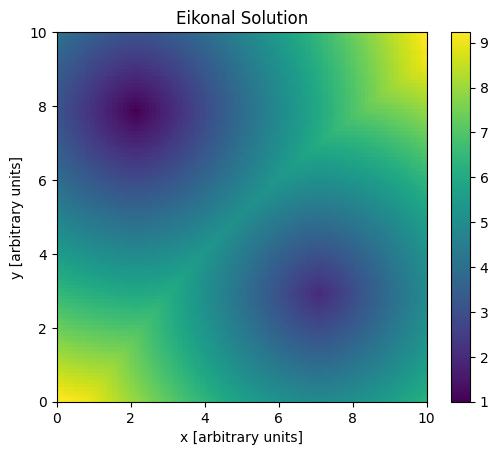

In [31]:
x = np.arange(0, N) * h
y = np.arange(0, N) * h

plt.figure(1)
plt.imshow(u, extent=(x[0], x[-1], y[0], y[-1]))
plt.colorbar()
plt.xlabel('x [arbitrary units]')
plt.ylabel('y [arbitrary units]')
plt.title('Eikonal Solution')
plt.show()

In [35]:
uFS = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/FS_result.txt', dtype=int)
err = 100 * np.sqrt(np.sum(np.abs(u - uFS)**2) / np.sum(np.abs(u)**2))
print(err)

11.413372269361927
